### Image To Image Translation Model

In [1]:
import os
import time
import numpy as np
import pandas as pd
import logging

import matplotlib.pyplot  as plt

from lpips import LPIPS

import torch
import torch.nn            as nn
import torch.nn.functional as F

from torch.nn.utils           import clip_grad_norm_
from torch.utils.data         import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard  import SummaryWriter
from torch.optim              import Adam
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler

from torchvision            import transforms
from torchvision.transforms import Grayscale

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

from PIL import Image

from sklearn.model_selection import train_test_split
from skimage.morphology import disk
from math import log10

logging.getLogger('lpips').setLevel(logging.WARNING)

/Users/andrei.aioanei/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project path in Google Colab

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

PROJECT_PATH = '/content/drive/My Drive/Research Hub/Projects/Present Projects/{Deep Hadad}/Implementation/DeepHadadProject/'

Local Project path

In [2]:
PROJECT_PATH = './'

In [3]:
import sys
sys.path.append(PROJECT_PATH)

import core.networks as dh_networks

### Constants

In [4]:
MODEL_PATH        = PROJECT_PATH + 'models/'
MODEL_NAME        = 'generator_model_v1.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### TensorBoard

In [10]:
%load_ext tensorboard
%tensorboard --logdir 'runs/experiment_1'

### Generating a restored image from a broken one

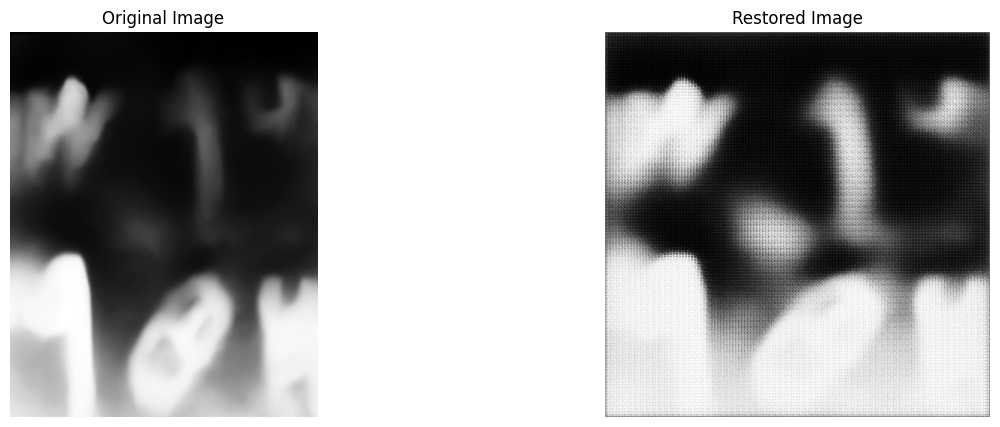

FileNotFoundError: [Errno 2] No such file or directory: './test/restored_image.png'

In [40]:

gen_in_channels  = 1  # grayscale images, 3 for RGB images
gen_out_channels = 1  # to generate grayscale restored images, change as needed

# Instantiate the generator with the specified channel configurations
generator = dh_networks.DHadadGenerator(gen_in_channels, gen_out_channels).to(device)


checkpoint = torch.load(MODEL_PATH + MODEL_NAME, map_location=device)

# Load the pre-trained weights
generator.load_state_dict(checkpoint)

# Set the model to evaluation mode
generator.eval()

transform = transforms.Compose([
  transforms.Resize((512, 512)),
  transforms.Lambda(lambda x: x.convert('L')),
  transforms.ToTensor()
])

# Load and transform the broken image
broken_image_path = PROJECT_PATH + "data/test_dataset/KAI 214/d_m_test_16.png"
broken_image_pil = Image.open(broken_image_path) #.convert('L')
broken_image_tensor = transform(broken_image_pil).to(device)

# Turn off gradients for testing
with torch.no_grad():
    # Add a batch dimension
    broken_image = broken_image_tensor.unsqueeze(0).to(device)

    # Generate the restored image and remove the batch dimension
    restored_image = generator(broken_image).squeeze(0).cpu()

# Invert the pixel values
restored_image = 1.0 - restored_image

# Normalize the image to the range [0, 1]
restored_image = (restored_image - restored_image.min()) / (restored_image.max() - restored_image.min())

# Convert the tensor to a PIL Image and show/save it
restored_image_pil = transforms.ToPILImage()(restored_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Show original image
axes[0].imshow(broken_image_pil, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Show restored image
axes[1].imshow(restored_image_pil, cmap='gray')
axes[1].set_title('Restored Image')
axes[1].axis('off')

plt.show()

restored_image_pil.save(PROJECT_PATH + "test/restored_image.png")
